In [39]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [40]:
np.random.seed(28)  # for reproducibility

In [41]:
df = pd.read_csv('data.csv', index_col='datetime', parse_dates=True)

In [42]:
df

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...
2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168


In [43]:
df.shape

(10886, 11)

## <font color='purple'> BUT: On cherche à prédire le nombre de vélos loués par heure dans la ville (variable `count`).</font>

# [ **I ) Analyse exploratoire**](#content1)

# [ **II ) Modélisation**](#content2) 

# [ **III ) Explication des modèles & sens métier aux prédictions**](#content3)

<a id="content1"></a>
# <font color='black'>I) Analyse exploratoire</font>
### - Par quelles étapes passes-tu afin de prendre en main la donnée avant de passer à la modélisation ?
### - Quels sont les facteurs qui semblent influencer la demande en vélos ? Illustrer à l'aide de graphiques

$\,$


### Checker les valeurs manquantes

In [44]:
df_null = (df.isnull().sum()) / len(df) * 100
#df_na = df.drop(df[df==0].index).sort_values(by='count', ascending=False)
df_null.head(12)

season        0.0
holiday       0.0
workingday    0.0
weather       0.0
temp          0.0
atemp         0.0
humidity      0.0
windspeed     0.0
casual        0.0
registered    0.0
count         0.0
dtype: float64

Il n'y a pas de valeurs manquantes dans chacunes des colonnes.

In [45]:
df_na = (df.isna().sum()) / len(df) * 100
df_na.head(12)

season        0.0
holiday       0.0
workingday    0.0
weather       0.0
temp          0.0
atemp         0.0
humidity      0.0
windspeed     0.0
casual        0.0
registered    0.0
count         0.0
dtype: float64

Ni de `NaN` valeurs.

### Types des valeurs: catégoriques & numériques

On crée des colonnes temporelles dont nous aurons besoin tels que l'heure, le jour de la semaine, le mois etc. Ces dernières permettront de mieux prédire le nombre total de locations (nous le verrons dans la partie 'modélisation'.

In [46]:
# Create hours, days, weeks, months, year 
df['week_number'] = df.index.week
df['day_month'] = df.index.day
df['year'] = df.index.year
df['months'] = df.index.month
df['day'] = df.index.dayofweek
df['hour'] = df.index.hour
df['weekend'] = (df['day'] > 4).astype(int)

In [47]:
df.dtypes

season           int64
holiday          int64
workingday       int64
weather          int64
temp           float64
atemp          float64
humidity         int64
windspeed      float64
casual           int64
registered       int64
count            int64
week_number      int64
day_month        int64
year             int64
months           int64
day              int64
hour             int64
weekend          int64
dtype: object

In [48]:
# Check for categorical values
print('-'*35)
print('First 5 uniques values from columns')
print('-'*35, '\n')
for col in df.columns:
    print(f'- {col} : {df[col].unique()[:5]}')

-----------------------------------
First 5 uniques values from columns
----------------------------------- 

- season : [1 2 3 4]
- holiday : [0 1]
- workingday : [0 1]
- weather : [1 2 3 4]
- temp : [ 9.84  9.02  8.2  13.12 15.58]
- atemp : [14.395 13.635 12.88  17.425 19.695]
- humidity : [81 80 75 86 76]
- windspeed : [ 0.      6.0032 16.9979 19.0012 19.9995]
- casual : [3 8 5 0 2]
- registered : [13 32 27 10  1]
- count : [16 40 32 13  1]
- week_number : [52  1  2  3  5]
- day_month : [1 2 3 4 5]
- year : [2011 2012]
- months : [1 2 3 4 5]
- day : [5 6 0 1 2]
- hour : [0 1 2 3 4]
- weekend : [1 0]


Avant la modélisation 'partie Feature engineering on transformera certaines colonnes en catégoriques.

In [49]:
df.describe(include='all')

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,week_number,day_month,year,months,day,hour,weekend
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132,25.917784,9.992559,2011.501929,6.521495,3.013963,11.541613,0.290557
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454,15.017269,5.476608,0.500019,3.444373,2.004585,6.915838,0.454040
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,2011.000000,1.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000,14.000000,5.000000,2011.000000,4.000000,1.000000,6.000000,0.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000,26.000000,10.000000,2012.000000,7.000000,3.000000,12.000000,0.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000,40.000000,15.000000,2012.000000,10.000000,5.000000,18.000000,1.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000,52.000000,19.000000,2012.000000,12.000000,6.000000,23.000000,1.000000


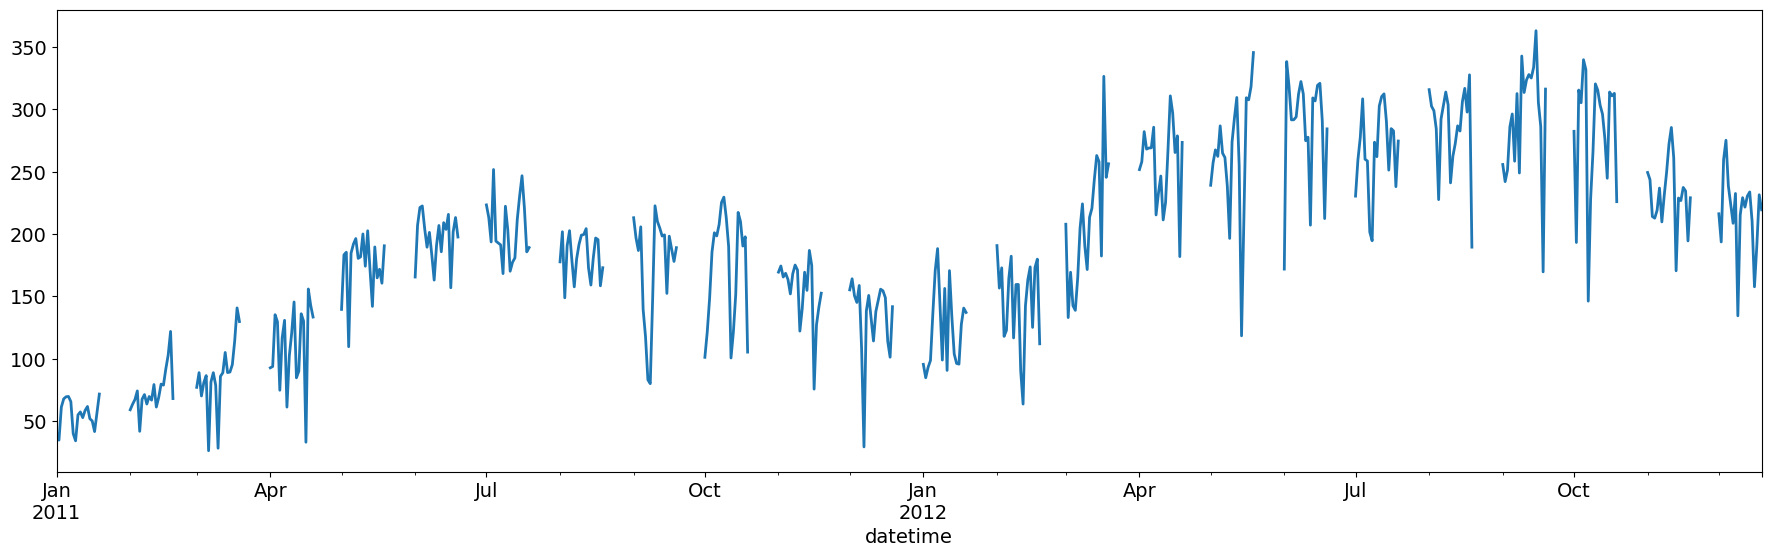

In [50]:
df_day = df.groupby(pd.Grouper(freq='d'))

with plt.rc_context(rc={'font.size':14}): 
    fig, ax = plt.subplots(figsize=(22,6))
    df_day['count'].mean().plot(ax=ax, lw=2)

In [51]:
# Check the data consistency
df[:500:24].index

DatetimeIndex(['2011-01-01 00:00:00', '2011-01-02 00:00:00',
               '2011-01-03 01:00:00', '2011-01-04 04:00:00',
               '2011-01-05 05:00:00', '2011-01-06 06:00:00',
               '2011-01-07 07:00:00', '2011-01-08 07:00:00',
               '2011-01-09 07:00:00', '2011-01-10 07:00:00',
               '2011-01-11 09:00:00', '2011-01-12 11:00:00',
               '2011-01-13 11:00:00', '2011-01-14 12:00:00',
               '2011-01-15 12:00:00', '2011-01-16 12:00:00',
               '2011-01-17 12:00:00', '2011-01-19 00:00:00',
               '2011-02-01 01:00:00', '2011-02-02 02:00:00',
               '2011-02-03 02:00:00'],
              dtype='datetime64[ns]', name='datetime', freq=None)

**Remarque: Il n'y a des données que jusqu'au 19 du mois.**

In [52]:
# Really basic basic fit
from sklearn.linear_model import LinearRegression

X = df.drop(columns=['count', 'casual', 'registered'], axis=1)
y = df['count']
model = LinearRegression(fit_intercept=False)
model.fit(X, y)
df['predicted'] = model.predict(X)

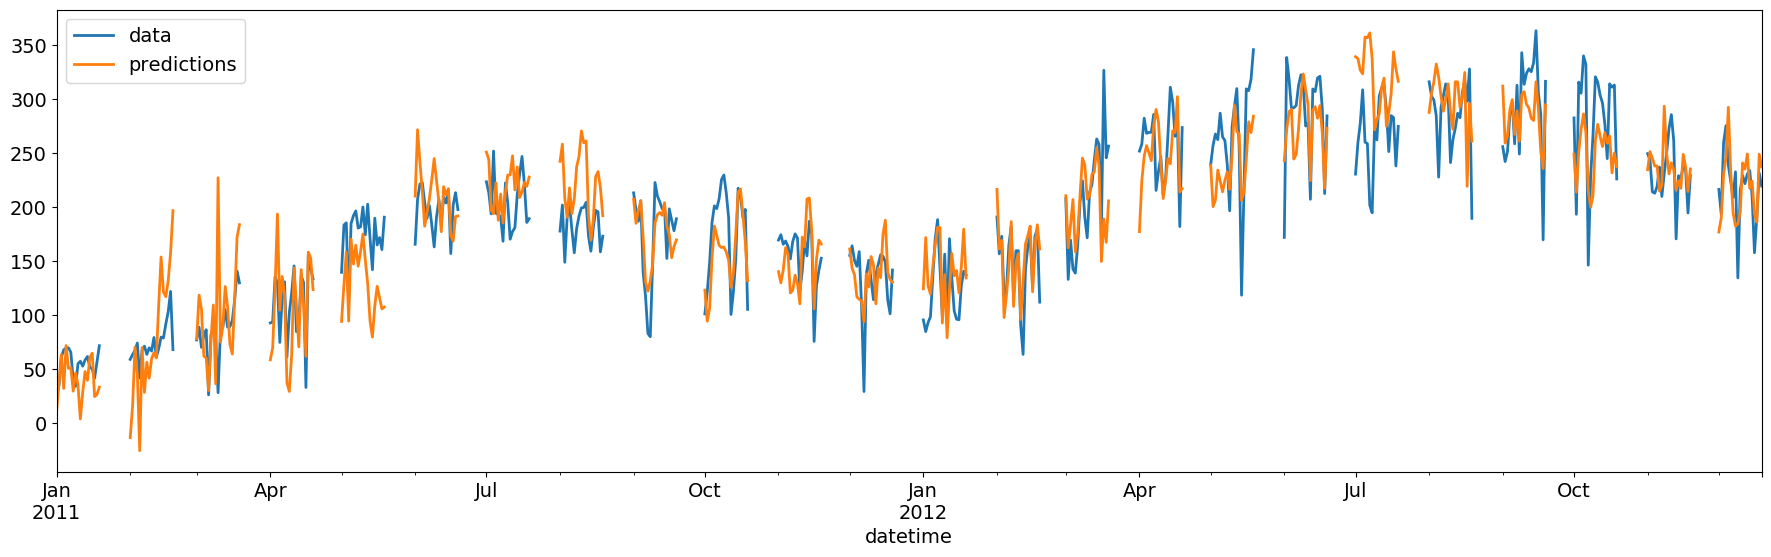

In [53]:
df_day = df.groupby(pd.Grouper(freq='d'))

with plt.rc_context(rc={'font.size':14}): 
    fig, ax = plt.subplots(figsize=(22,6))
    df_day['count'].mean().plot(ax=ax, lw=2, label='data')
    df_day['predicted'].mean().plot(ax=ax, lw=2, label='predictions')
    ax.legend(loc='best')

In [19]:
from sklearn.utils import resample
params = pd.Series(model.coef_, index=X.columns)
err = np.std([model.fit(*resample(X, y)).coef_ 
              for i in range(300)], 0)
pd.DataFrame({'params': params.round(0), 'error': err.round(0)})

,params,error
season,-7.0,5.0
holiday,-166567.0,5141.0
workingday,-166562.0,5140.0
weather,-5.0,2.0
temp,2.0,1.0
atemp,5.0,1.0
humidity,-2.0,0.0
windspeed,1.0,0.0
week_number,-0.0,0.0
day_month,0.0,0.0


In [20]:
from sklearn.ensemble import RandomForestRegressor
clr = RandomForestRegressor(n_estimators=200, n_jobs=-1)
clr.fit(X,y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

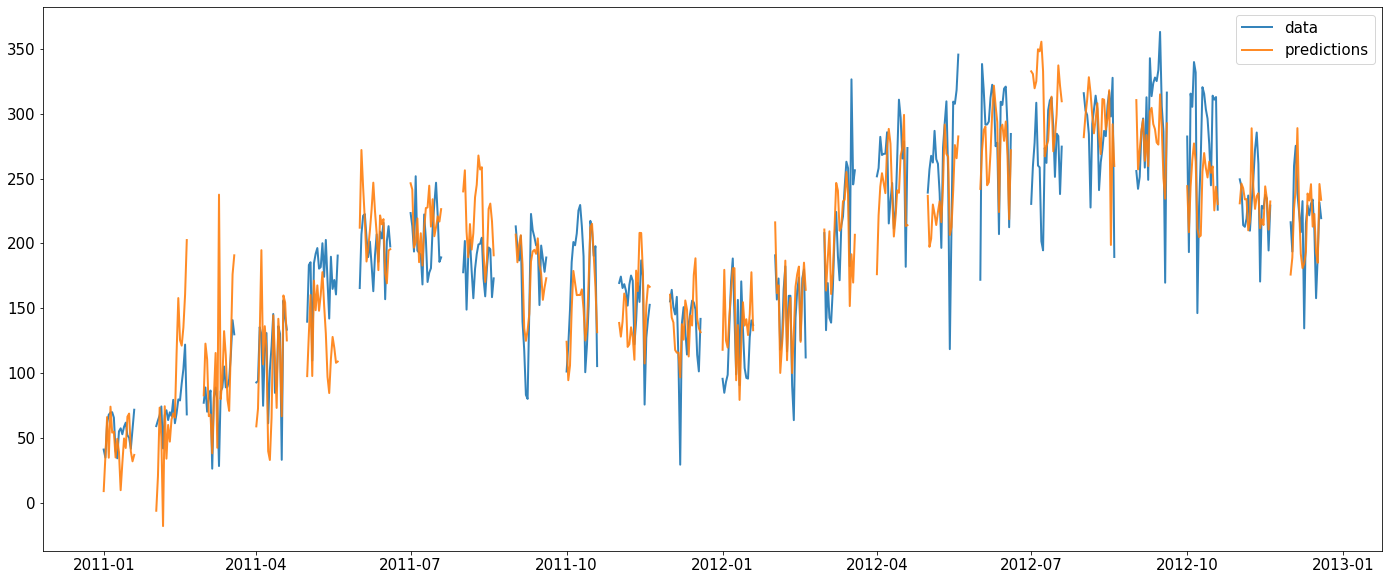

In [21]:
df['predicted'] = model.predict(X)
df_day = df.groupby(pd.Grouper(freq='d'))
x, y = df_day['count'].mean().index, df_day['count'].mean().values
xp, yp = df_day['predicted'].mean().index, df_day['predicted'].mean().values

with plt.rc_context(rc={'font.size':15}): 
    fig, ax = plt.subplots(figsize=(24,10))
    line, = ax.plot(x, y, alpha=0.9, linewidth=2, label='data')
    #ax.fill_between(x, y1=y, y2=-y, alpha=0.1, linewidth=2, color=line.get_color())
    linep, = ax.plot(xp, yp, alpha=0.9, linewidth=2, label='predictions')   
    #ax.fill_between(xp, y1=yp, y2=-yp, alpha=0.4, linewidth=2, color=linep.get_color())
    ax.legend(loc='best')

In [22]:
params = pd.Series(model.coef_, index=X.columns)
pd.DataFrame({'params': params.round(0)})
#err = np.std([model.fit(*resample(X, y)).coef_ for i in range(300)], 0)
#pd.DataFrame({'params': params.round(0), 'error': err.round(0)})

,params
season,-13.0
holiday,-158979.0
workingday,-158983.0
weather,-2.0
temp,1.0
atemp,5.0
humidity,-2.0
windspeed,1.0
week_number,-0.0
day_month,0.0


### **Étude avec les données *catégoriques***

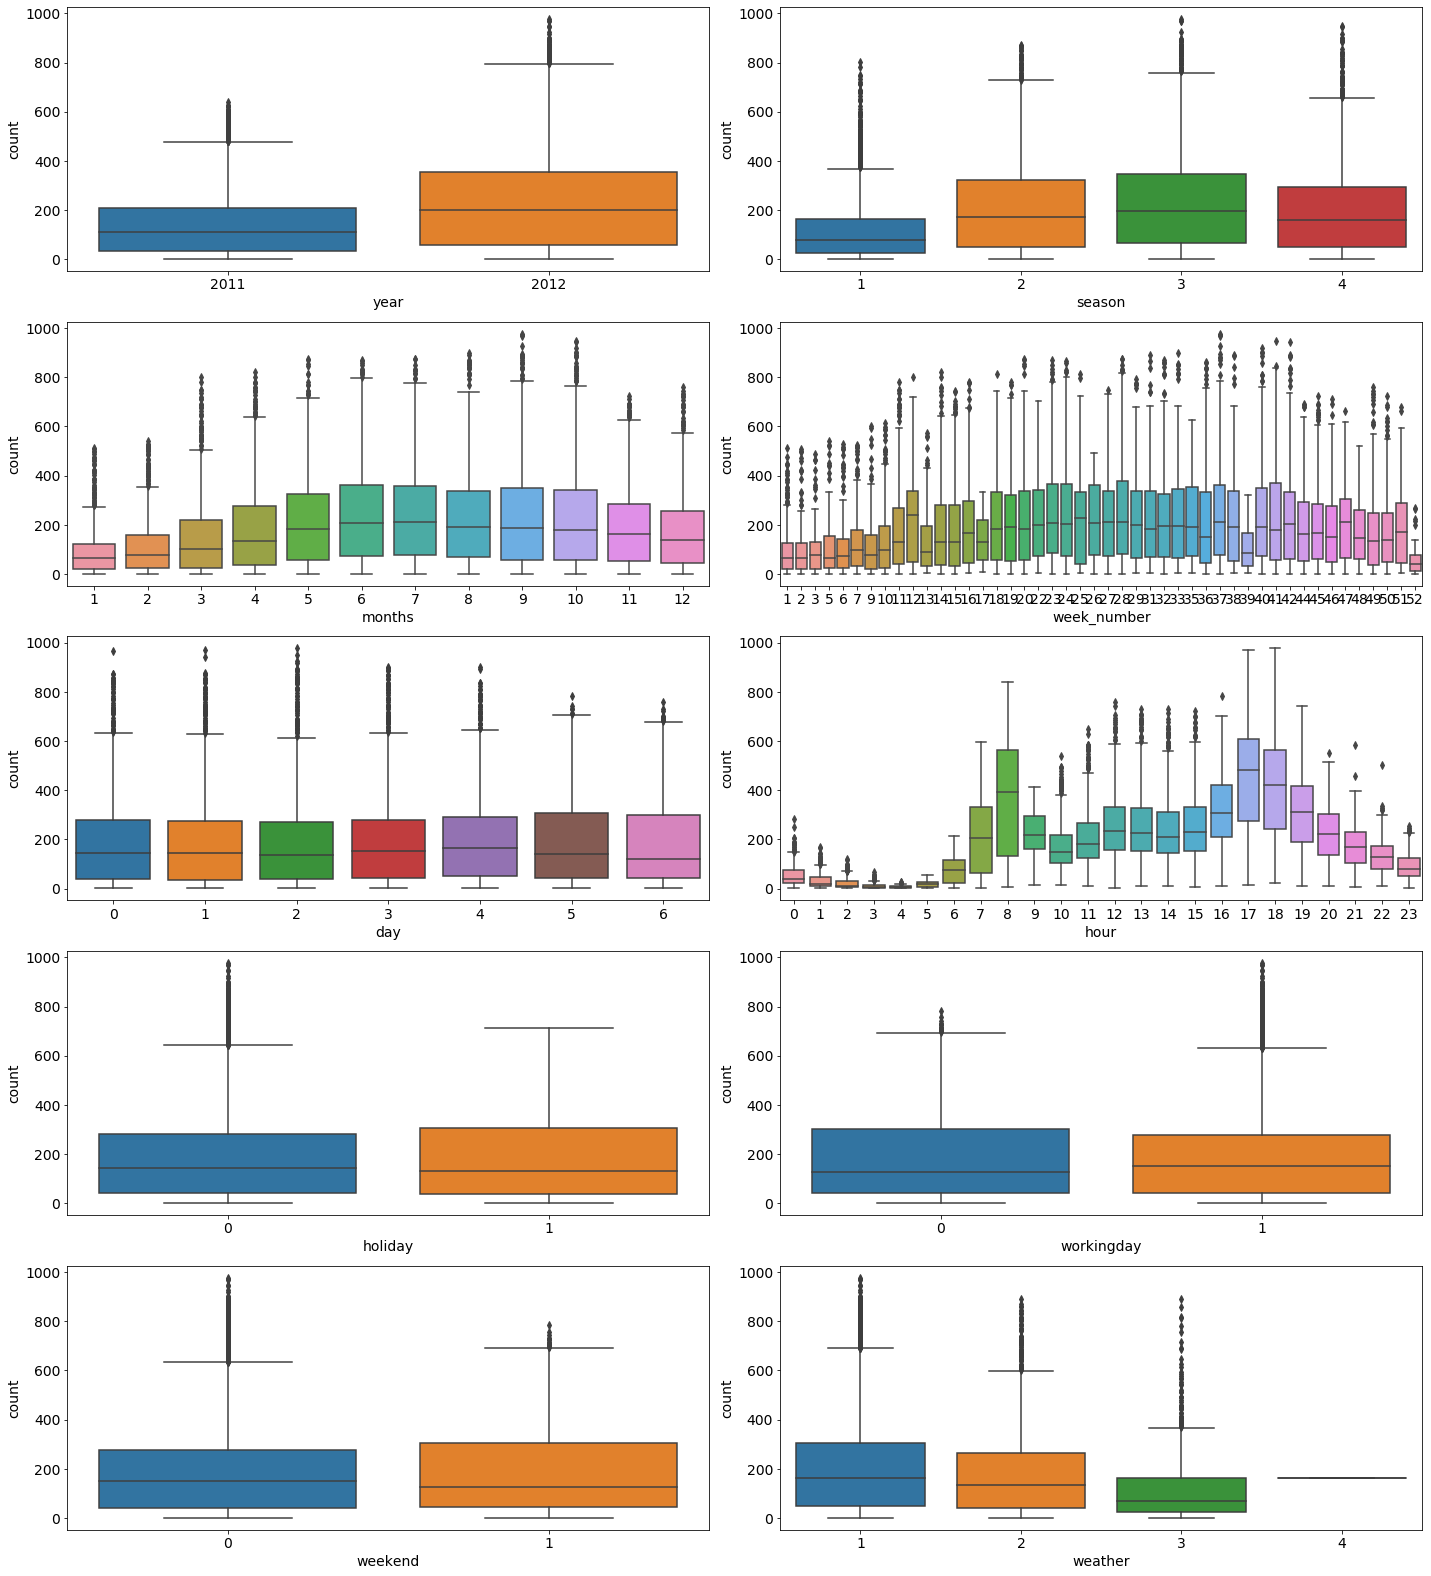

In [178]:
cols = 'year season months week_number day hour holiday workingday weekend  weather'.split()

with plt.rc_context(rc={'font.size':14}): 
    fig, ((ax1,ax2),(ax3,ax4),(ax5,ax6), (ax7,ax8), (ax9,ax10)) = plt.subplots(5,2, figsize=(20,22), tight_layout=True)       
    for col, ax in zip(cols, [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10]):       
        sns.boxplot(x=df[col], y=df['count'], ax=ax)

À partir de ces distributions on peut déjà noter quelques résultats sur le nombre **total** de locations (qui seront à confirmer par la suite lors d'études statistiques plus fines):
- augmentation de ~ 60% de 2011 à 2012
- locations plus importantes l'été et l'automne 
- locations

### **Corrélations**
Avant de faire du *features engineering*, on va s'intéresser aux colonnes les plus corrélés avec la *target* (`count`).

In [190]:
# Finding the correlations
corr = df.corr()   
print(corr['count'].sort_values(ascending=False))

count          1.000000
registered     0.970948
casual         0.690414
hour           0.400601
temp           0.394454
atemp          0.389784
year           0.260403
months         0.166862
season         0.163439
week_number    0.152512
windspeed      0.101369
day_month      0.019826
workingday     0.011594
day           -0.002283
holiday       -0.005393
weekend       -0.009925
weather       -0.128655
humidity      -0.317371
Name: count, dtype: float64


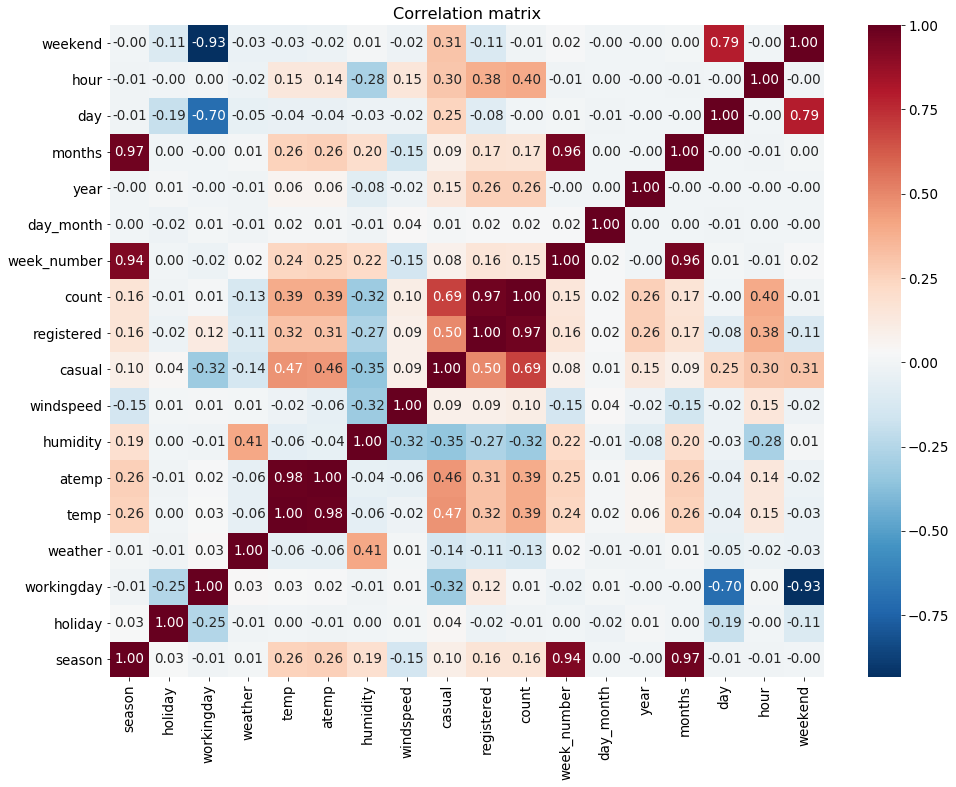

In [200]:
# Most correlated variables
threshold = 0
top_corr_features = corr.index[np.abs(corr['count']) > threshold]
#print(top_corr_features)

# Plot correlation
with plt.rc_context(rc={'font.size':13.5}): 
    fig, ax = plt.subplots(figsize=(16, 12))
    sns.heatmap(df[top_corr_features].corr(), annot=True, 
                fmt='.2f', cmap='RdBu_r', ax=ax)
    ax.set(ylim=[0, 18], title='Correlation matrix')

Il y a plein d'informations utiles:
- **week number** est très corrélé avec la variable **mois** et très peu avec le nombre total de locations on pourra donc l'enlever lors de la modélisation
- **weekend** est très corrélé avec **workingday**, il suffira donc de considérer uniquement l'une de ces 2 variables

Globalement, cela permet d'avoir un indice sur les composantes qui impactent le plus le nombre de locations / heures:
- **registered**, **casual**, **hour**, **temp** sont les principales

Toutefois, du fait que registered + casual = count, afin de prédire **count** nous n'utiliserons pas les colonnes registered et count

### **Variables numériques**

### **Count - Température**

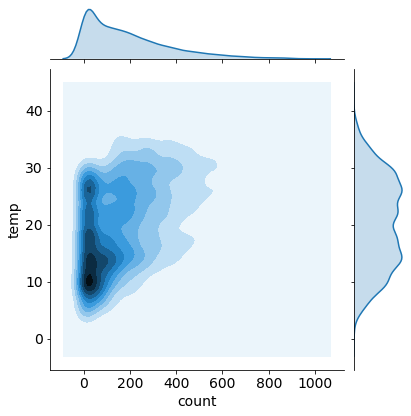

In [45]:
# 2D KDE plot - Correlations
with plt.rc_context(rc={'font.size':14}): 
    sns.jointplot(x=df['count'], y=df['temp'], kind='kde')       # temperature  

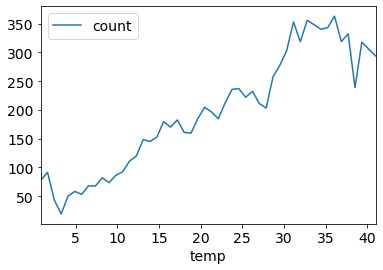

In [75]:
with plt.rc_context(rc={'font.size':14}): 
    df.pivot_table(index='temp', values='count', aggfunc='mean').plot()

### **Température - Ressentie**

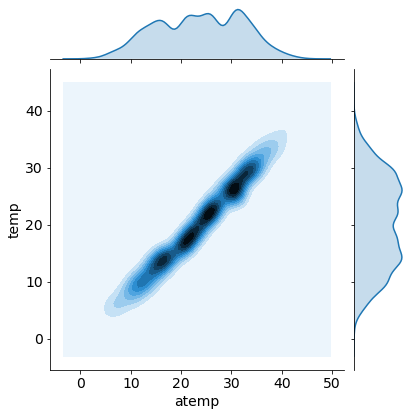

In [144]:
# 2D KDE plot - Correlations
with plt.rc_context(rc={'font.size':14}): 
    sns.jointplot(x=df['atemp'], y=df['temp'], kind='kde')       # temperature  

In [147]:
print(f'Pearson coefficient: {stats.pearsonr(df.temp, df.atemp)[0]:.2f}')

Pearson coefficient: 0.98


**Nous n'utiliserons donc pas la variable *atemp* lors des prédictions (info redondante qui peut biaiser les modèles car cela engendrerait de la *multicolinearity*)**.

### **Count - Humidité**

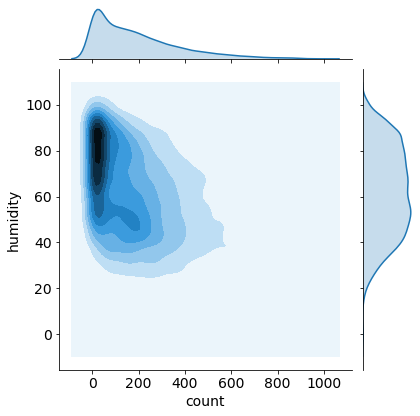

In [180]:
with plt.rc_context(rc={'font.size':14}): 
    sns.jointplot(x=df['count'], y=df['humidity'], kind='kde')       # humidity  

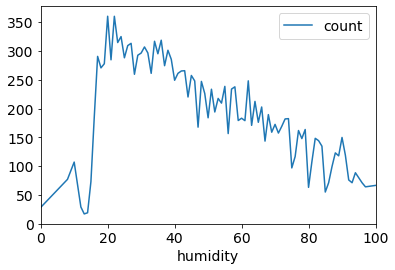

In [76]:
with plt.rc_context(rc={'font.size':14}): 
    df.pivot_table(index='humidity', values='count', aggfunc='mean').plot()

### **Count - Windspeed**

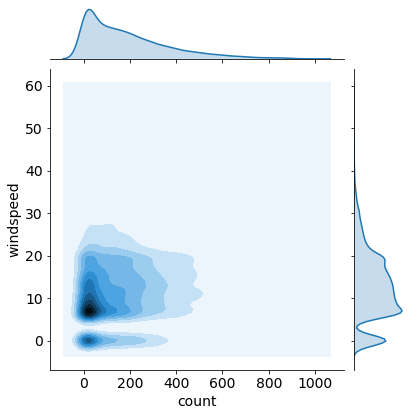

In [148]:
with plt.rc_context(rc={'font.size':14}): 
    sns.jointplot(x=df['count'], y=df['windspeed'], kind='kde')       # windspeed  

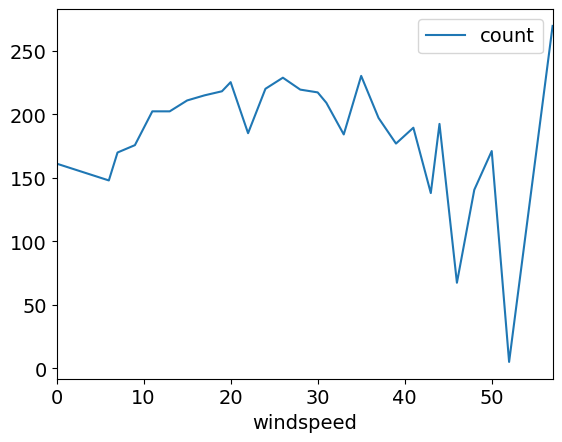

In [25]:
with plt.rc_context(rc={'font.size':14}): 
    df.pivot_table(index='windspeed', values='count', aggfunc='mean').plot()

## **Dépendance temporelle** (dans la journée, dans la semaine, dans l'année)

In [55]:
months = 'Jan. Feb. March April May June July Aug. Sept. Oct. Nov. Dec.'.split()
days = 'lundi mardi mercredi jeudi vendredi samedi dimanche'.split()

### <font color='Black'>**Évolution annuelle**</font>

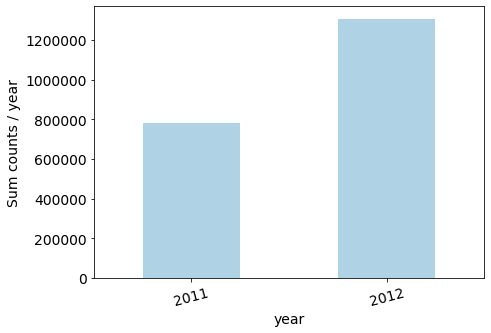

In [204]:
with plt.rc_context(rc={'font.size':14}): 
    fig, ax = plt.subplots(figsize=(7,5))
    df.groupby('year')['count'].sum().plot(kind='bar', alpha=0.9, ax=ax)
    ax.set(ylabel='Sum counts / year')
    ax.tick_params(axis='x', rotation=15)

In [206]:
sum_year = df.groupby('year')['count'].sum().values
augm = sum_year[1] / sum_year[0] 
print(f'Augmentation du nombre total de locations de {(augm - 1)*100:.1f}% entre 2011 et 2012')

Augmentation du nombre total de locations de 66.7% entre 2011 et 2012


### <font color='Black'>**Évolution le long des 24 mois**</font>

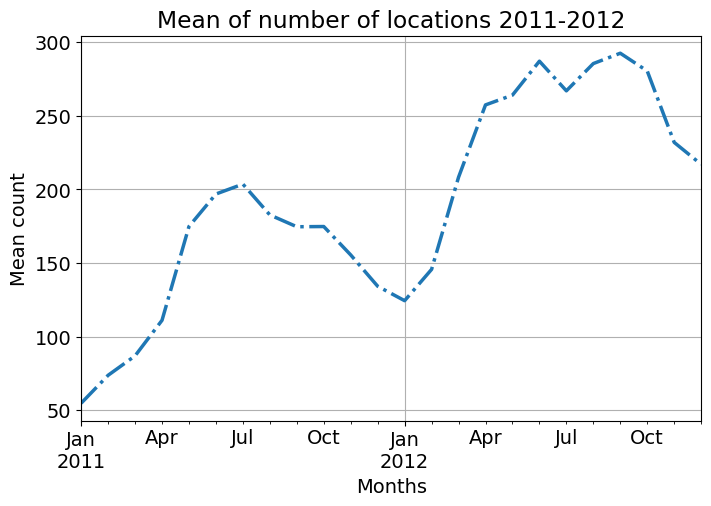

In [26]:
df_month = df.groupby(pd.Grouper(freq='M'))
with plt.rc_context(rc={'font.size':14}): 
    fig, ax = plt.subplots(figsize=(8,5))     
    df_month['count'].mean().plot(ax=ax, ls='-.', lw=2.5)
    ax.set(title='Mean of number of locations 2011-2012', 
           xlabel='Months', ylabel='Mean count')
    ax.grid()

On peut ainsi remarquer une tendance ! Examinons cela de plus près.

In [33]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Import Data
data = df.groupby(pd.Grouper(freq='M'))
data = data['count'].mean()

# Multiplicative Decomposition 
result_mul = seasonal_decompose(data, model='multiplicative', extrapolate_trend='freq')

# Additive Decomposition
result_add = seasonal_decompose(data, model='additive', extrapolate_trend='freq')

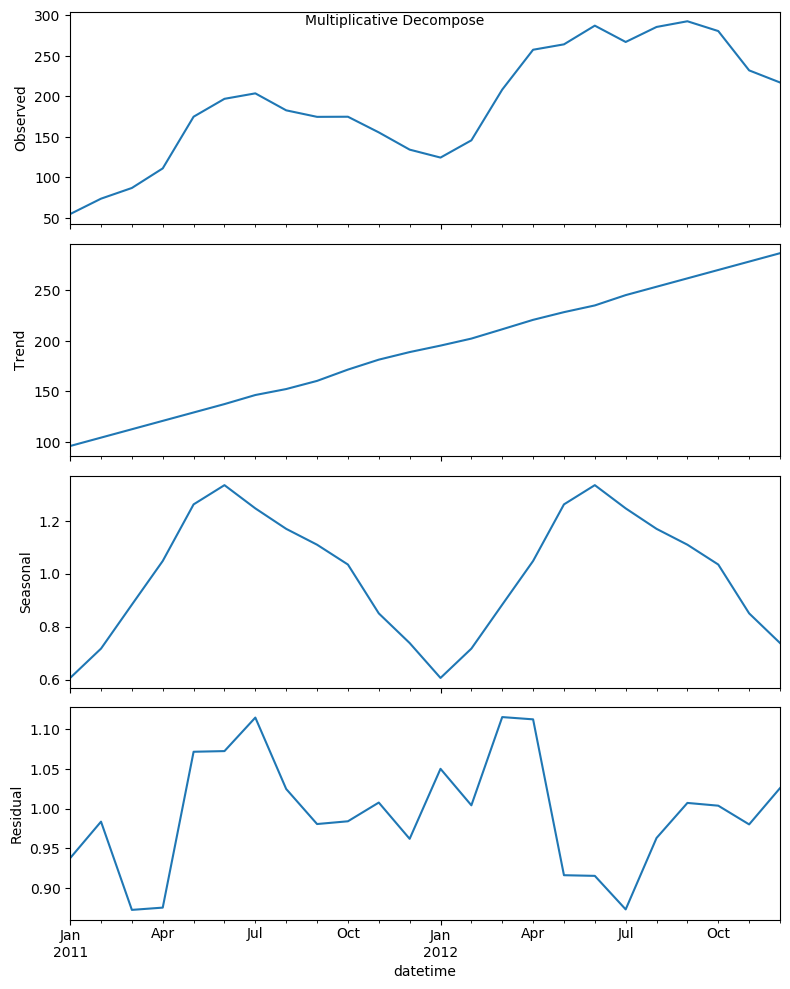

In [28]:
plt.rcParams['figure.figsize'] = (8,10)

result_mul.plot().suptitle('Multiplicative Decompose', fontsize=10)

Cela fournit déjà un première idée de la tendance générale du nombre totale de locations. Bien sûr par la suite on va utiliser des modèles plus complexes afin de prédire au mieux ce nombre. Il sera intéressant à la fin de comparer nos modèles de ML avec ce modèle-ci.

In [35]:
#result_add.plot().suptitle('Additive Decompose', fontsize=12)

### <font color='Black'>**Évolution mensuelle**</font>

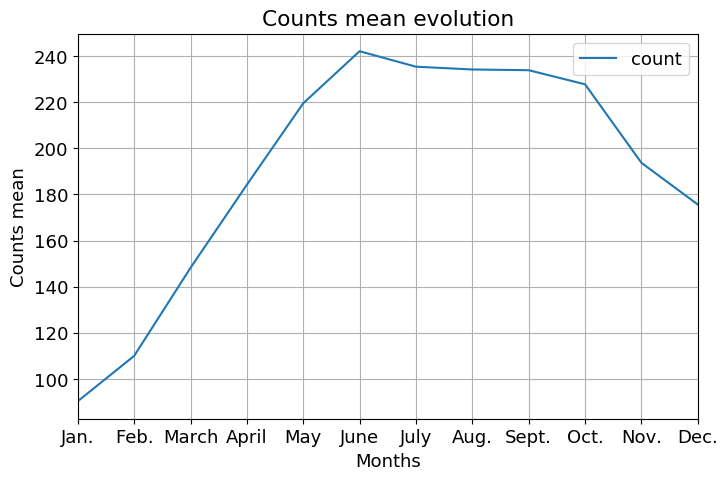

In [58]:
with plt.rc_context(rc={'font.size':13}): 
    fig, ax = plt.subplots(figsize=(8,5))
    df.pivot_table(values='count', index='months', aggfunc='mean').plot(ax=ax)
    ax.set(xlabel='Months', ylabel='Counts mean', title='Counts mean evolution', 
           xticklabels=months, xticks=np.arange(1,13))
    ax.grid()

### <font color='Red'> Évolution hebdomadaire</font>

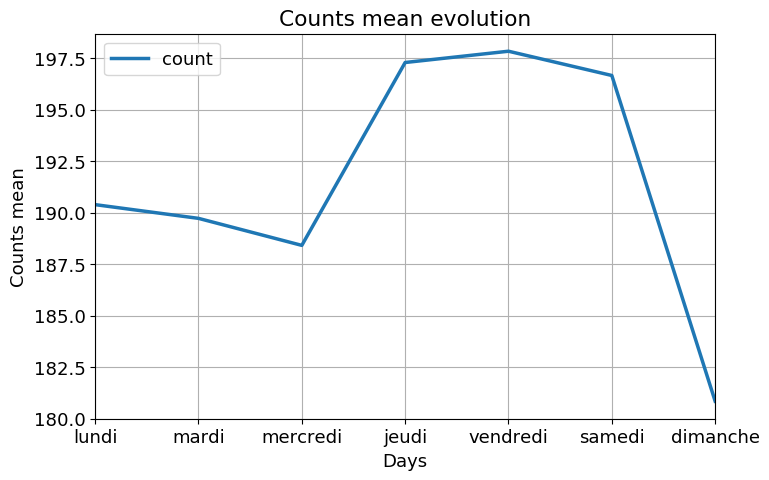

In [60]:
with plt.rc_context(rc={'font.size':13}): 
    fig, ax = plt.subplots(figsize=(8,5))
    df.pivot_table(values='count', index='day', aggfunc='mean').plot(ax=ax, lw=2.5)
    ax.set(xlabel='Days', ylabel='Counts mean', title='Counts mean evolution', 
           xticklabels=days)
    ax.grid()

### <font color='Red'>***Évolution journalière***</font> 
(but de l'étude)

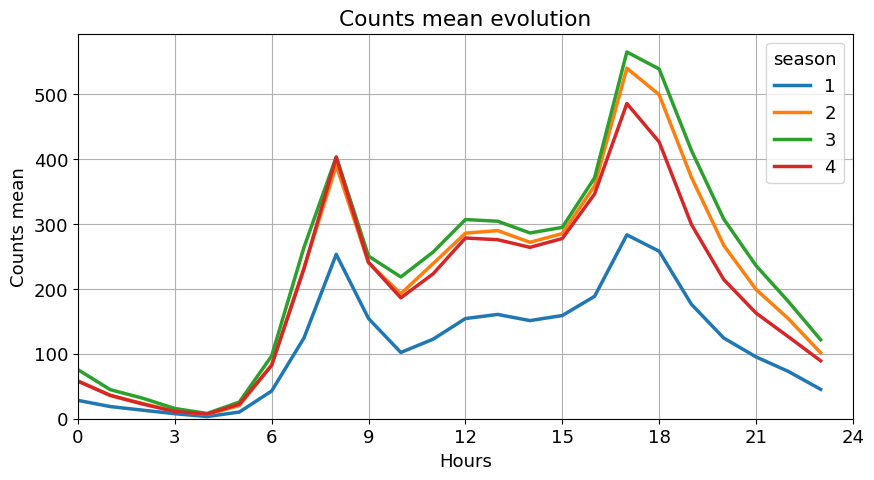

In [37]:
with plt.rc_context(rc={'font.size':13}): 
    fig, ax = plt.subplots(figsize=(10,5))
    df.pivot_table(values='count', index='hour', columns='season', aggfunc='mean').plot(ax=ax, lw=2.5)
    ax.set(xticks=np.arange(0,27,3), ylim=[0, plt.ylim()[1]],
           xlabel='Hours', ylabel='Counts mean', title='Counts mean evolution')
    ax.grid()

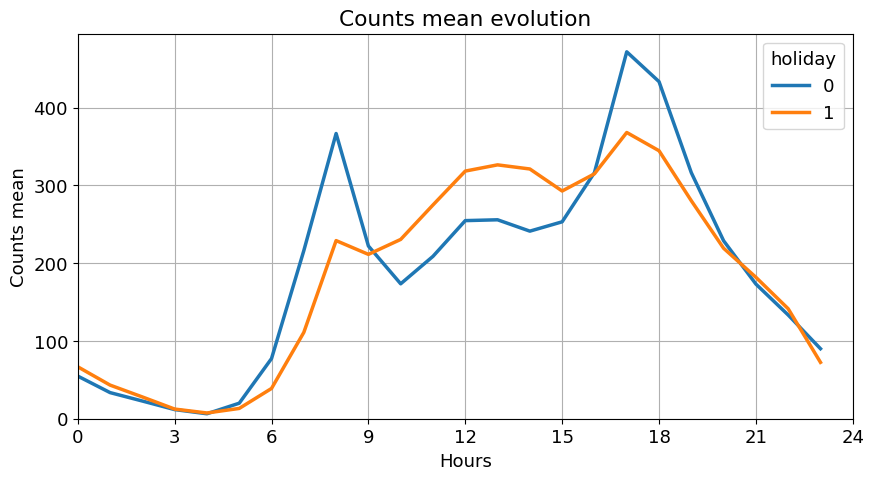

In [38]:
with plt.rc_context(rc={'font.size':13}): 
    fig, ax = plt.subplots(figsize=(10,5))
    df.pivot_table(values='count', index='hour', columns='holiday', aggfunc='mean').plot(ax=ax, lw=2.5)
    ax.set(xticks=np.arange(0,27,3), ylim=[0, plt.ylim()[1]],
           xlabel='Hours', ylabel='Counts mean', title='Counts mean evolution')
    ax.grid()

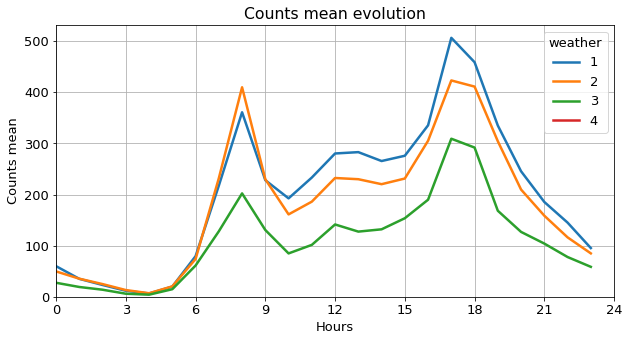

In [57]:
with plt.rc_context(rc={'font.size':13}): 
    fig, ax = plt.subplots(figsize=(10,5))
    df.pivot_table(values='count', index='hour', columns='weather', aggfunc='mean').plot(ax=ax, lw=2.5)
    ax.set(xticks=np.arange(0,27,3), ylim=[0, plt.ylim()[1]],
           xlabel='Hours', ylabel='Counts mean', title='Counts mean evolution')
    ax.grid()

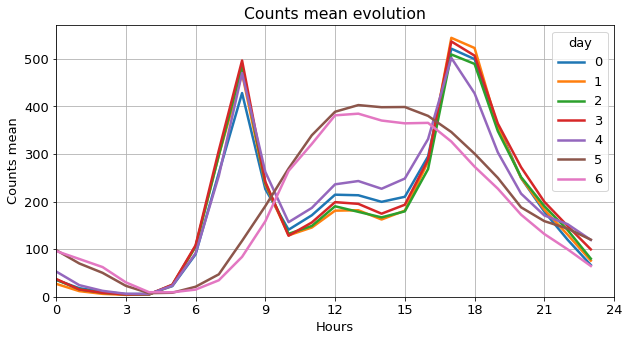

In [53]:
with plt.rc_context(rc={'font.size':13}): 
    fig, ax = plt.subplots(figsize=(10,5))
    df.pivot_table(values='count', index='hour', columns='day', aggfunc='mean').plot(ax=ax, lw=2.5)
    ax.set(xticks=np.arange(0,27,3), ylim=[0, plt.ylim()[1]],
           xlabel='Hours', ylabel='Counts mean', title='Counts mean evolution')
    ax.grid()

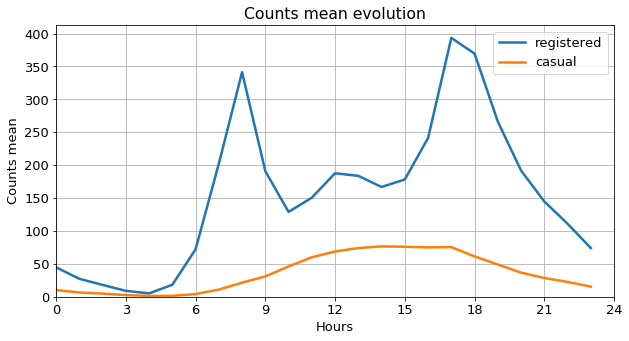

In [51]:
with plt.rc_context(rc={'font.size':13}): 
    fig, ax = plt.subplots(figsize=(10,5))
    df.pivot_table(values='registered', index='hour', aggfunc='mean').plot(ax=ax, lw=2.5)
    df.pivot_table(values='casual', index='hour', aggfunc='mean').plot(ax=ax, lw=2.5)    
    ax.set(xticks=np.arange(0,27,3), ylim=[0, plt.ylim()[1]],
           xlabel='Hours', ylabel='Counts mean', title='Counts mean evolution')
    ax.grid()

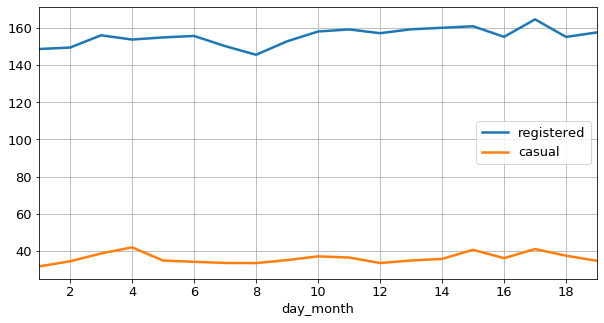

In [17]:
with plt.rc_context(rc={'font.size':13}): 
    fig, ax = plt.subplots(figsize=(10,5))
    df.pivot_table(values='registered', index='day_month', aggfunc='mean').plot(ax=ax, lw=2.5)
    df.pivot_table(values='casual', index='day_month', aggfunc='mean').plot(ax=ax, lw=2.5)    
    #ax.set(xticks=np.arange(0,27,3), ylim=[0, plt.ylim()[1]],
    #       xlabel='Hours', ylabel='Counts mean', title='Counts mean evolution')
    ax.grid()

On peut observer 2 pics de locations de vélos de 6 à 9h et de 16 à 19h: axés sur les horaires de travail.

### Tranche en degré [0-20 20-40] et plotter dans la journée l'impact pareil avec taux d'humidité et la vitesse du vent 

### ***Tendances abonnées vs. non abonnés***

In [182]:
def plot_count_categ(hue, titles, col='months', fontsize=12):
    with plt.rc_context(rc={'font.size':fontsize}): 
        fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,4))
        sns.lineplot(x=col, y='count', data=df, hue=hue, ax=ax1)
        sns.lineplot(x=col, y='registered', data=df, hue=hue, ax=ax2)
        sns.lineplot(x=col, y='casual', data=df, hue=hue, ax=ax3)
        for t, ax in zip(titles, [ax1,ax2,ax3]):
            ax.set(title=t)
titles = 'Total_count Registered Casual'.split()

#### **Week-end**

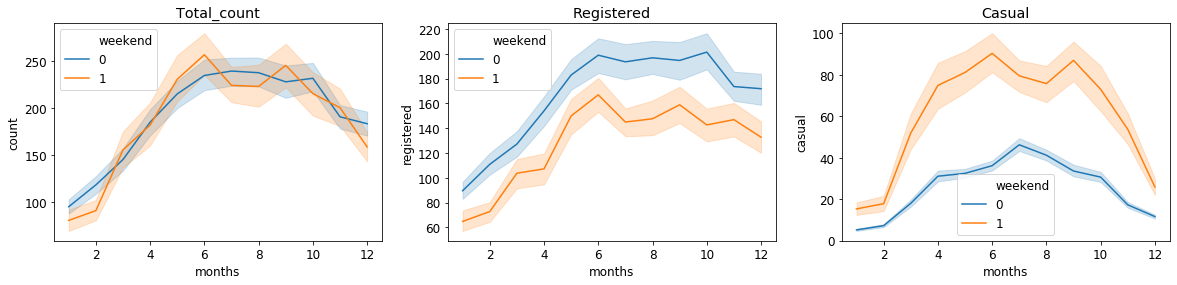

In [159]:
plot_count_categ('weekend', titles)

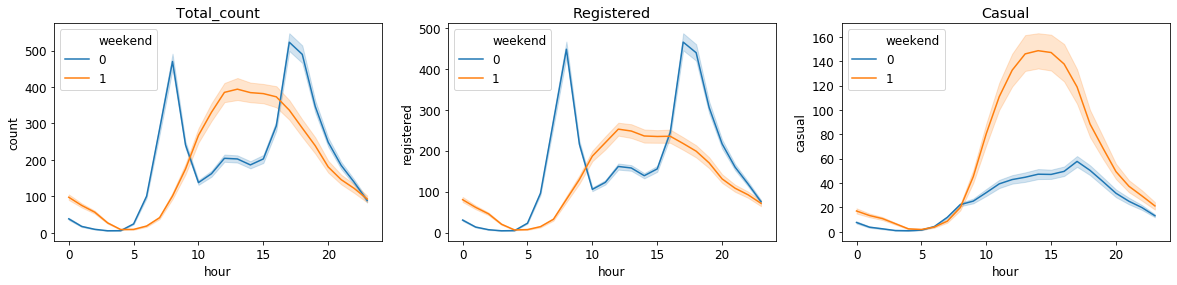

In [162]:
plot_count_categ('weekend', titles, col='hour')

#### **Working-day**

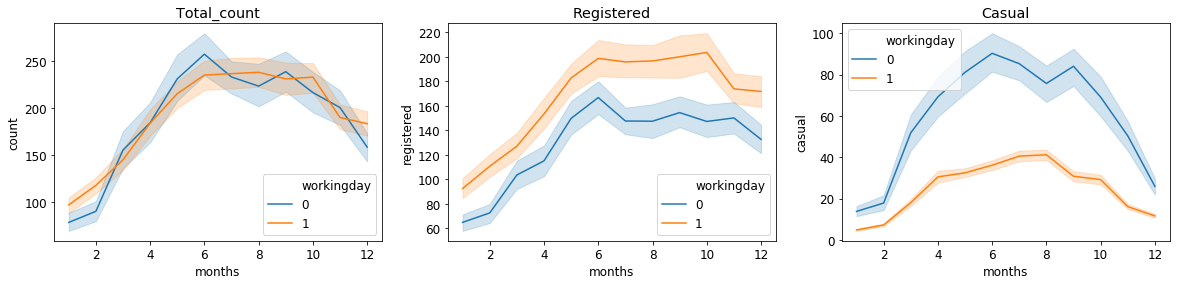

In [59]:
plot_count_categ('workingday', titles)

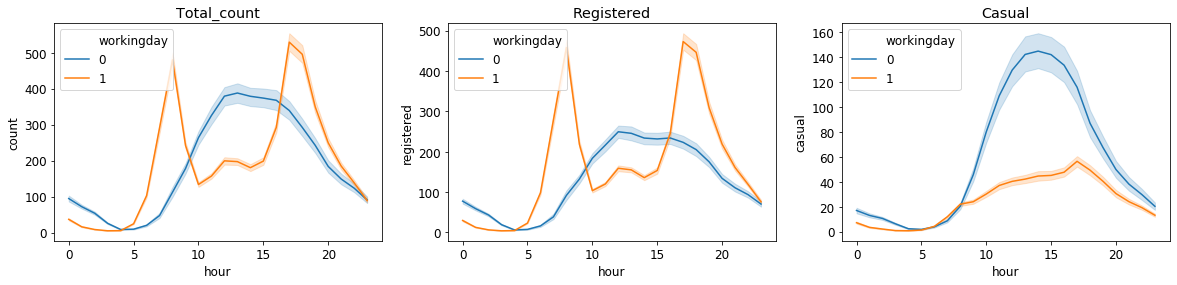

In [163]:
plot_count_categ('workingday', titles, col='hour')

#### **Holiday**

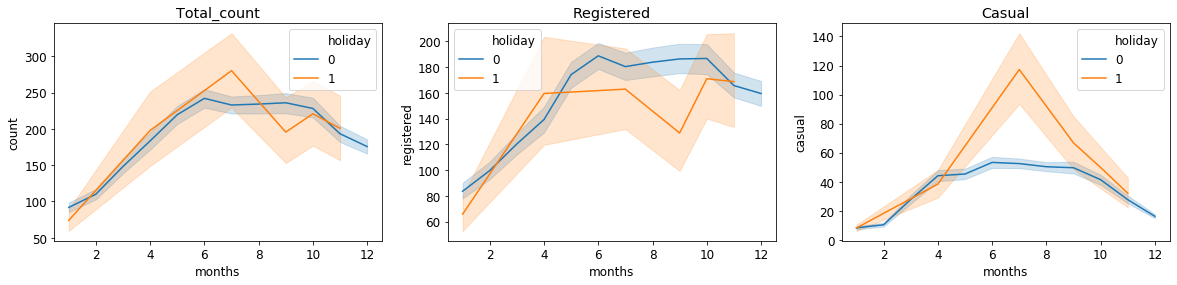

In [60]:
plot_count_categ('holiday', titles)

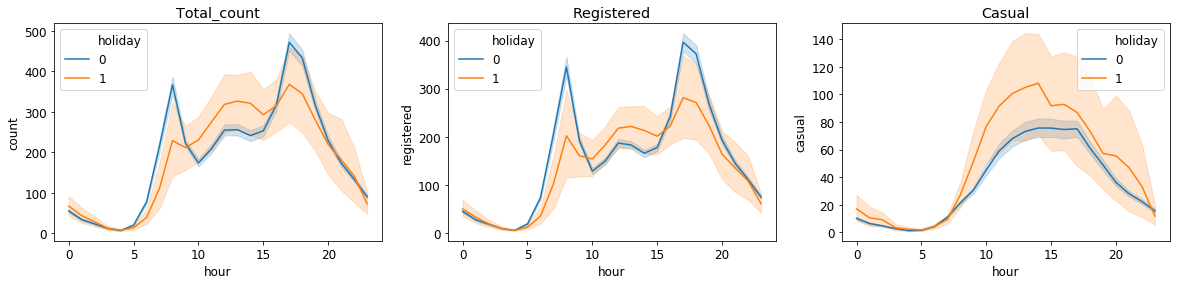

In [165]:
plot_count_categ('holiday', titles, col='hour')

#### **Weather**

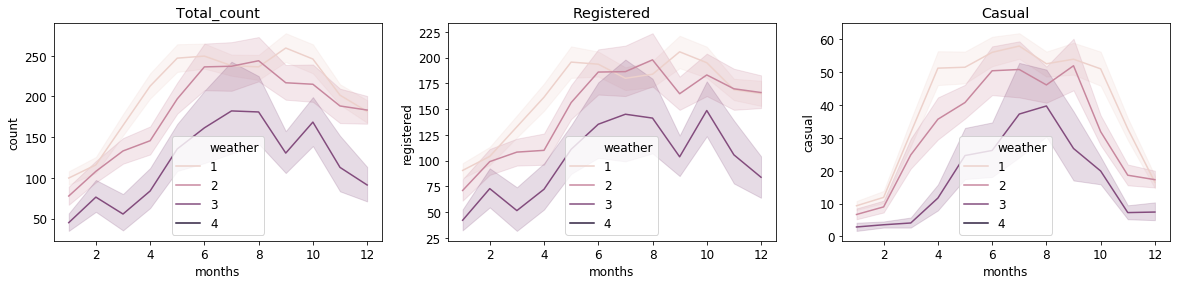

In [61]:
plot_count_categ('weather', titles)

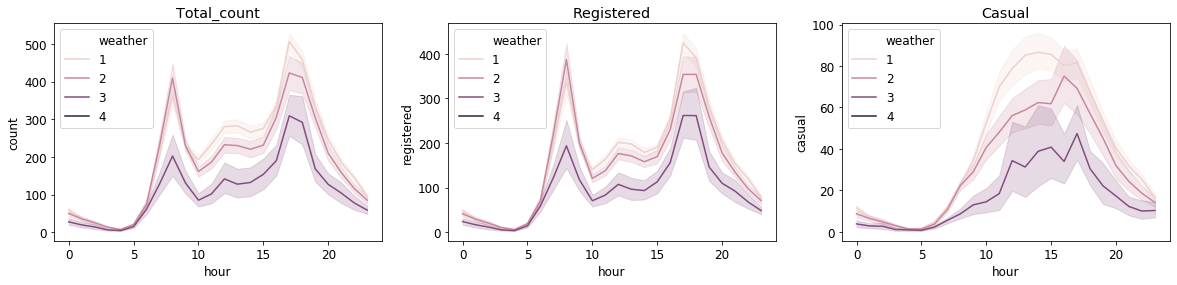

In [164]:
plot_count_categ('weather', titles, col='hour')

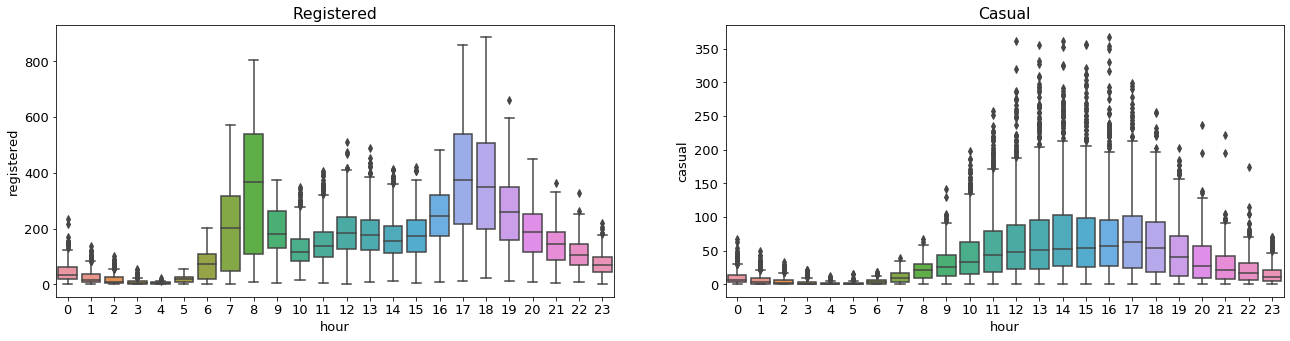

In [157]:
with plt.rc_context(rc={'font.size':13}): 
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(22,5))
    sns.boxplot(x='hour', y='registered', data=df, ax=ax1)
    sns.boxplot(x='hour', y='casual', data=df, ax=ax2)
    for t, ax in zip('Registered Casual'.split(), [ax1,ax2]):
        ax.set(title=t)

In [62]:
df['casual'].describe()

count    10886.000000
mean        36.021955
std         49.960477
min          0.000000
25%          4.000000
50%         17.000000
75%         49.000000
max        367.000000
Name: casual, dtype: float64

On peut remarquer des *outliers* des usagers non abonnés qui se réfletent au sein de la distribution totale $\rightarrow$ **log-transformation** pour 'normaliser' la distribution count.

### **Total des locations**

In [182]:
#Info on our target variable
df['count'].describe()

count    10886.000000
mean       191.574132
std        181.144454
min          1.000000
25%         42.000000
50%        145.000000
75%        284.000000
max        977.000000
Name: count, dtype: float64

The count skewness is 1.24


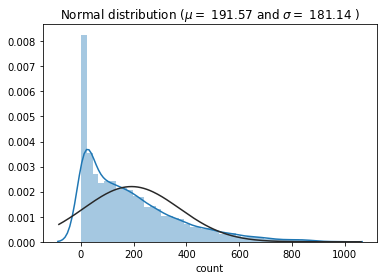

In [183]:
# Check distribution
def skew_distribution(data, col='count'):
    fig, ax1 = plt.subplots()
    sns.distplot(data[col], ax=ax1, fit=stats.norm)
    (mu, sigma) = stats.norm.fit(data[col])
    ax1.set(title='Normal distribution ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma))

    #fig, ax2 = plt.subplots()
    #stats.probplot(data[col], plot=plt)
    print('The {} skewness is {:.2f}'.format(col, stats.skew(data[col])))

skew_distribution(df)

<img src='https://saylordotorg.github.io/text_essentials-of-geographic-information-systems/section_10/e8b3fa38d26678631d8c8c2c7822011b.jpg' width='600'>

*To apply ML models, it is better to have normal distributions! Hence, a way to check that is to compute the skewness.*

The count skewness is 0.06


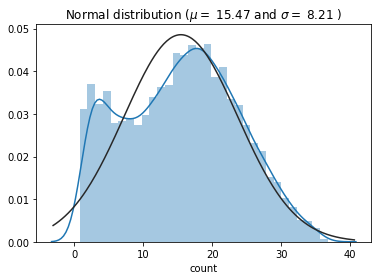

In [223]:
from scipy.special import boxcox1p, inv_boxcox1p

#data = df.copy()
df['count'] = boxcox1p(df['count'], 0.4)
skew_distribution(df)

--> pivot table avec tranches en jours de la semaine pd.cut: [lundi, vendredi] et [samedi, dimanche] et plotter évolution en fonction des heures pour ces 2 tranches de la semaine.

--> voir si c'est intéressant de créer après coup 2 features: df['semaine'] et df['week-end']
--> df['Morning'], df['Evening'], df['WorkingTime'] tranche horaires 6-9h, 16-19h, 9-16h 
--> meme grahe mais avec pd.cut[2011, 2012]

## Feature engineering time !
#### Créer des features qui ont plus de sens (et vérifier a posteriori si ces new features ont de *l'importance* via des modèles comme `Lasso` ou `RandomForrest`)

In [58]:
cols = 'season holiday workingday weather week_number day_month year months day hour weekend'.split()

for col in cols:
    df[col] = df[col].astype(str)

In [59]:
num_cols = df.select_dtypes(exclude='object').columns
print('{} Numeric columns \n-----------------\n{}'.format(len(num_cols), num_cols.values))

categ_cols = df.select_dtypes(include='object').columns
print('\n{} Categorical columns \n----------------------\n{}'.format(len(categ_cols), categ_cols.values))

7 Numeric columns 
-----------------
['temp' 'atemp' 'humidity' 'windspeed' 'casual' 'registered' 'count']

11 Categorical columns 
----------------------
['season' 'holiday' 'workingday' 'weather' 'week_number' 'day_month'
 'year' 'months' 'day' 'hour' 'weekend']


In [ ]:
df['count'] = coxplot lamnbda=0.15

In [ ]:
for col in ['casual', 'registered', 'count']:
    df['%s_log' % col] = np.log1p(df[col])

In [ ]:
# rush, ideal and sticky variables
df['rush'] = df[['hour', 'workingday']].apply(lambda x: (0, 1)[(x['workingday'] == 1 and 
                                                                (7<= x['hour'] <=9 or 17 <= x['hour'] <= 18 or 12 <= x['hour'] <= 12)) 
                                                                or (x['workingday'] == 0 and  10 <= x['hour'] <= 19)], 
                                                                axis = 1)

df['ideal'] = df[['temp', 'windspeed']].apply(lambda x: (0, 1)[x['temp'] > 27 and x['windspeed'] < 30], axis = 1)
df['sticky'] = df[['humidity', 'workingday']].apply(lambda x: (0, 1)[x['workingday'] == 1 and x['humidity'] >= 60], axis = 1)

In [ ]:
weather=pd.get_dummies(df['weather'],prefix='weather')
df=pd.concat([df,weather],axis=1)
df.head()
weather=pd.get_dummies(test_df['weather'],prefix='weather')
test_df=pd.concat([test_df,weather],axis=1)
test_df.head()

In [ ]:
weather_df=pd.get_dummies(new_df['weather'],prefix='w')
year_df=pd.get_dummies(new_df['year'],prefix='y',drop_first=True)
month_df=pd.get_dummies(new_df['month'],prefix='m',drop_first=True)
hour_df=pd.get_dummies(new_df['hour'],prefix='h',drop_first=True)
season_df=pd.get_dummies(new_df['season'],prefix='s',drop_first=True)


final_df=final_df.join(weather_df)
final_df=final_df.join(year_df)
final_df=final_df.join(month_df)                     
final_df=final_df.join(hour_df)
final_df=final_df.join(season_df)

In [ ]:
df.columns.to_series().groupby(df.dtypes).groups


In [106]:
columns = df.columns.drop(['count', 'registered', 'casual'])
X = df[columns].values
y = df['count'].values

<a id="content2"></a>
# <font color='blue'>II) Modélisation</font>
### - Construis un premier modèle permettant de prédire la variable count et explique ton choix et ta démarche.
### - Evalue la performance de ton modèle et explique le critère de performance choisi.
### - Quelles pistes d’améliorations imagines-tu ? $\rightarrow$ 
- more feature engineering
- implementer abonnées et casual clients and predict count with separates models
- get more year data (2012-2020) and study autocorrelation to build robust model of seasonality
- GridSearch on more hyperparams
- Stacked models to get better predictors

In [125]:
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_val_score
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

In [109]:
def compute_rmse(ytrue, ypred):
    return np.sqrt(mean_squared_error(ytrue, ypred))

def compute_rmsle(ytrue, ypred):
    return np.sqrt(mean_squared_log_error(ytrue, ypred))

In [ ]:
# Baseline model
mean of target --> RMSLE = 

In [ ]:
models=[RandomForestRegressor(),AdaBoostRegressor(),BaggingRegressor(),SVR(),KNeighborsRegressor()]
model_names=['RandomForestRegressor','AdaBoostRegressor','BaggingRegressor','SVR','KNeighborsRegressor']
rmsle=[]
d={}
for model in range (len(models)):
    clf=models[model]
    clf.fit(x_train,y_train)
    test_pred=clf.predict(x_test)
    rmsle.append(np.sqrt(mean_squared_log_error(test_pred,y_test)))
res = {'Modelling Algo':model_names,'RMSLE':rmsle}   
res

In [ ]:
rmsle_df = pd.DataFrame(res)
rmsle_df

In [ ]:
sns.factorplot(y='ML Models',x='RMSLE',data=rmsle_df, 
               kind='bar', size=5, aspect=2)

### ***Diviser les données en train/test***

On ne peut pas utiliser un `train_test_split` de façon classique car ici ce sont des données temporelles. Cela pourrait conduire à du `data leakage` si des données `test` étaient comprises entre des données `train`.

In [123]:
tscv = TimeSeriesSplit(n_splits=5)

for train_index, test_index in tscv.split(df):
    df_train, df_test = df.iloc[train_index, :], df.iloc[test_index, :]
    print("TRAIN:", df_train.shape, "TEST:", df_test.shape)

TRAIN: (1816, 18) TEST: (1814, 18)
TRAIN: (3630, 18) TEST: (1814, 18)
TRAIN: (5444, 18) TEST: (1814, 18)
TRAIN: (7258, 18) TEST: (1814, 18)
TRAIN: (9072, 18) TEST: (1814, 18)


In [126]:
train_index

array([   0,    1,    2, ..., 9069, 9070, 9071])

In [ ]:
import warnings
clr = RandomForestRegressor()

def train_test(clr, train_index, test_index):
    data_train = df.iloc[train_index, :]
    data_test = df.iloc[test_index, :]
    clr.fit(data_train.drop(["value", "date", "notrend", "trend"],
                            axis=1),
            data_train.value)
    r2 = r2_score(data_test.value,
                  clr.predict(data_test.drop(["value", "date", "notrend",
                                              "trend"], axis=1).values))
    return r2

warnings.simplefilter("ignore")
last_test_index = None
for train_index, test_index in tscv.split(lagged):
    r2 = train_test(clr, train_index, test_index)
    if last_test_index is not None:
        r2_prime = train_test(clr, last_test_index, test_index)
        print(r2, r2_prime)
    else:
        print(r2)
    last_test_index = test_index

<a id="content2"></a>
# <font color='blue'>III) Plus loin</font>

- **Expliquer simplement 1 ou 2 méthodes qui existent aujourd’hui afin d’expliquer un modèle de machine learning et donner un sens métier à ces prédictions ?**

Application du Lasso très facile niveau représentation graphe --> permet d'avoir très facilement une idée des features/colonnes des données qui ont un *poids* dans la prédiction final du prix.
--> sens métier: ces features *non importantes* montrent par exemple que la saisonalité n'influe pas sur le nombre de locations -->. faire des tarifs d'été ne sont par exemple pas essentiels, ou encore faire des tickets week-end à transformer en tickets jeudi-dimanche ou jeudi-samedi 48h plutot plus avantageux : jeudi 18h --> dimanche 12h. 